# K means Clustering

In this notebook I will build a K means clustering algorithm from scratch.

In [1300]:
# Linear algebra
import numpy as np
# Plotting the data
import matplotlib.pyplot as plt
import seaborn as sns
# Creating data
from sklearn.datasets import make_blobs
# Scaling the data
from sklearn.preprocessing import StandardScaler
# For selecting a random starting point
import random


## Making some Synthetic data

<function matplotlib.pyplot.show(close=None, block=None)>

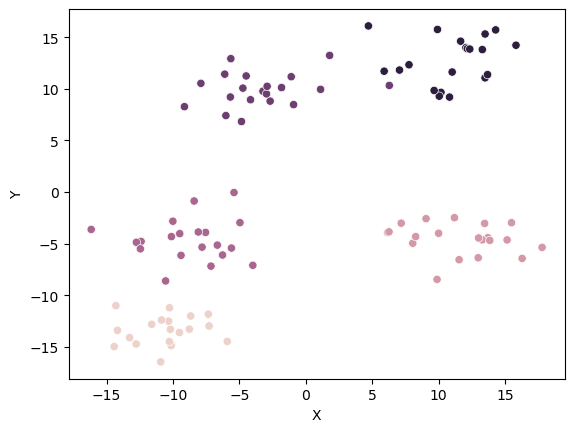

In [1301]:
Centers = 5 

# Using make blobs to make some synthetic data. # everything below works in more than 2 dimentions, but the plots are easiest
# to look at in 2.

x_train, y_train = make_blobs(n_samples = 100,n_features =2 ,centers = Centers , random_state= 40)

# It might be tempting to keep the distances at the usual standard scalar, however scaling everything by 10 greatly helps
# given that later we use standard deviation to decide on the best attempt so far, using larger numbers makes points futher
# away hurt even more. 
x_train = StandardScaler().fit_transform(x_train)*10

# Plotting the data

sns.scatterplot(x=[X[0] for X in x_train],
                y=[X[1] for X in x_train],
                hue = y_train, 
                legend = None)
plt.xlabel('X')
plt.ylabel('Y')
plt.show

In [1302]:
def distance(point, data):
    # Taking the standard euclidian distance for the distance between a point and our data
    return np.sqrt(np.sum((point-data)**2,axis=1 ))

In [1303]:
class K_Means:
    def __init__(self, n_clusters = 8, max_iter = 100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        

        
    def fit(self, x_train, attempts):
        
        # We need to run this a few times to find the best version so all of the code below will be wrapped in a loop, 
        # Starting with a random assortment of points just so we have something to begin with
        
        best_centers = [random.choice(x_train) for i in range(self.n_clusters)]
        best_centers_deviation = [float('inf') for i in range(self.n_clusters)]
        
        for attempt in range(attempts):
        
            # To choose a starting point so we can begin to cluster our data, choosing one of the data points as the starting point
            # will greatly decrease the amount of time it takes for the algorithm to converge.
            
            self.centers = [random.choice(x_train)]
            
            # I will use the Kmeans++ method to find good starting points faster, choosing centers to start is a np-hard problem,
            # and this method reduced the difficulty of finding them as an approximation.
            # The Kmeans++ method works by taking one random point, then working out the distances to all the other points and 
            # normalizing the distance and assigning them as probabilities, so the further from the first center has highest the 
            # probability of being chosen. This is repeated for the number of centers we are working with taking the previous 
            # centers into account. 
            
            
            for clust in range(self.n_clusters-1):
                # getting the distances to the current centers
                dists= np.sum([distance( centers, x_train) for centers in self.centers],axis=0)
                # normalizing so they can be probabilities
                dists = dists/np.sum(dists)
                # choosing a point based on how far it is
                new_centers_index = np.random.choice(range(len(x_train)),size = 1 , p = dists)[0]
                # adding hte new center
                self.centers += [x_train[new_centers_index]]
            
            # Now we are going to start iterating through to improve the fit of these starting centers. 
            
            Iter = 0
            
            prev_centers = self.centers
            
            while (np.not_equal(self.centers, prev_centers).any() and Iter < self.max_iter ) or Iter ==0:
                # Making a list for each of the centers so we can add the points to the centers
                sorted_points = [[] for cluster in range(self.n_clusters)]
                for x in x_train:
                    dists = distance(x, self.centers)
                    center_index = np.argmin(dists)
                    sorted_points[center_index].append(x)
                
                prev_centers = self.centers 
                self.centers = [np.mean(cluster,axis =0) for cluster in sorted_points]
                
                for i, center in enumerate(self.centers):
                    if np.isnan(center).any():
                        self.centers[i] = prev_centers[i]
                Iter += 1 
                
            # To evaluate the performance of the current best, based on the initial assignment , to do so we need two lists, the fist is the collection of points
            # sorted into a list of lists by which cluster they belong to.
            # the second is for the standard deviation of the cluster we are working with.
            
            sorted_points = [[] for cluster in range(self.n_clusters)]
            center_deviation = [[] for cluster in range(self.n_clusters)]
            
            # working out the assignments of points to clusters

            for x in x_train:
                dists = distance(x, self.centers)
                center_index = np.argmin(dists)
                sorted_points[center_index].append(x)
                
                # working out the standard deviation of the clusters, making sure to exclude any clusters that do not have any points by assigning them 0
                # it is rare but it does happen every now and again 
                
            for i, center in enumerate(self.centers):
                if len(sorted_points[i]) != 0:
                    center_deviation[i] =  np.sum(np.std(sorted_points[i],axis =1)**2)
                else:
                    center_deviation[i] = 0 
                    
                # Only keeping the result if it is better than all the previous attempts, the first attempt was inf so we always keep the first attempt.
                    
            if sum(center_deviation) < sum(best_centers_deviation):
                best_centers = self.centers
                best_centers_deviation = center_deviation
                
        # making sure we keep the best attempt so far only
                   
        self.centers = best_centers
    
    
    # A small function to sort any collection of points to its respective cluster, incase we want to use points that are not in the training set.
    def predict(self,X):
        centroids = []
        centroids_idxs = []
        for x in X:
            dist = distance(x,self.centers)
            centroids_idx = np.argmin(dist)
            centroids.append(self.centers[centroids_idx])
            centroids_idxs.append(centroids_idx)
        return centroids, centroids_idxs
                
                

In [1304]:
kmeans = K_Means(n_clusters=Centers, max_iter=100)
kmeans.fit(x_train,1000)


/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


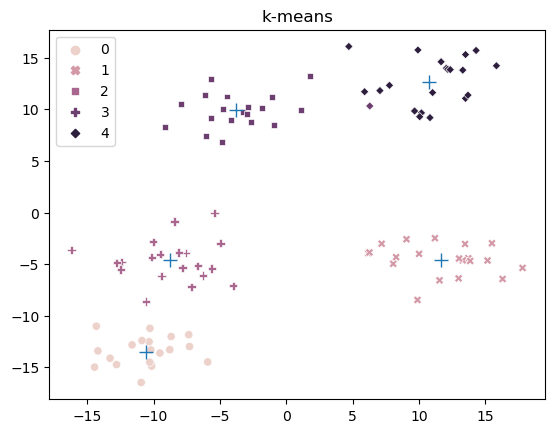

In [1305]:
# Having the model allocate points to the collection of points
class_centers, classification = kmeans.predict(x_train)
# Plotting the points and clusters

sns.scatterplot(x=[X[0] for X in x_train],
                y=[X[1] for X in x_train],
                # The colour shows the true label 
                hue=y_train,
                # THe shape shows how the code classifies the cluster
                style=classification,
                )
plt.plot([x for x, y in kmeans.centers],
         [y for x, y in kmeans.centers],
         '+',
         markersize=10,
         )
plt.title("k-means")
plt.show()